## Install OpenCV

In [ ]:
# If New Session Uncomment Line Below and Run
# Once OpenCV Installed Re-Comment Line Below and Restart Kernel & Clear Output
# --------------------------------------------------
# ! pip install opencv-python

## Imports

In [6]:
# Python Modules
# --------------------------------------------------
import os
import sys
import numpy             as np 
import pandas            as pd 
import matplotlib.pyplot as plt


# Custom Modules
# --------------------------------------------------
PATH = os.path.abspath(os.path.join(".."))

if PATH not in sys.path:
    sys.path.append(PATH)
    
import config
import utils

## Load X-ray Data

In [7]:
# Load Data
# --------------------------------------------------
all_xray_df            = pd.read_csv(config.ALL_XRAY_PATH)
all_xray_df            = utils.add_image_path(all_xray_df)
all_xray_df            = utils.add_disease_ind(all_xray_df)
all_xray_df[config.DV] = all_xray_df[config.TARGET_DISEASE].astype(str)

all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Class
48442,00012280_014.png,Infiltration,14,12280,53,M,AP,2500,2048,0.168000,...,0,0,0,1,0,0,0,0,0,0
83790,00020589_006.png,No Finding,6,20589,49,F,PA,2021,2021,0.194314,...,0,0,0,0,0,0,0,0,0,0
63248,00015624_004.png,No Finding,4,15624,56,M,AP,2500,2048,0.168000,...,0,0,0,0,0,0,0,0,0,0


## Filter Taining Data to Desired Cases

In [8]:
# Filter for Age 
# --------------------------------------------------
all_xray_df = all_xray_df[
    (all_xray_df["Patient Age"] >= config.YOUNGEST_AGE) &
    (all_xray_df["Patient Age"] <= config.OLDEST_AGE)
]

## Split Data

In [9]:
train_data, valid_data = utils.data_split(all_xray_df)

Removing Train Patient IDs from Valid
Cases Removed: 1137

Train Data Image Count:   2234
Train Data Patient Count: 1705
Train Data Positive:      0.5
Train Data Negative:      0.5

Validation Data Image Count:   680
Validation Data Patient Count: 645
Validation Data Positive:      0.2
Validation Data Negative:      0.8



## Data Generator

In [10]:
train_gen = utils.data_gen(
    data       = train_data, 
    split      = "train", 
    batch_size = config.TRAIN_BATCH_SIZE,
    image_size = config.IMG_SIZE
)

valid_gen = utils.data_gen(
    data       = valid_data,   
    split      = "valid",   
    batch_size = config.VALID_BATCH_SIZE,
    image_size = config.IMG_SIZE
)

Found 2234 validated image filenames belonging to 2 classes.
Found 680 validated image filenames belonging to 2 classes.


## View Data Augmentation Result

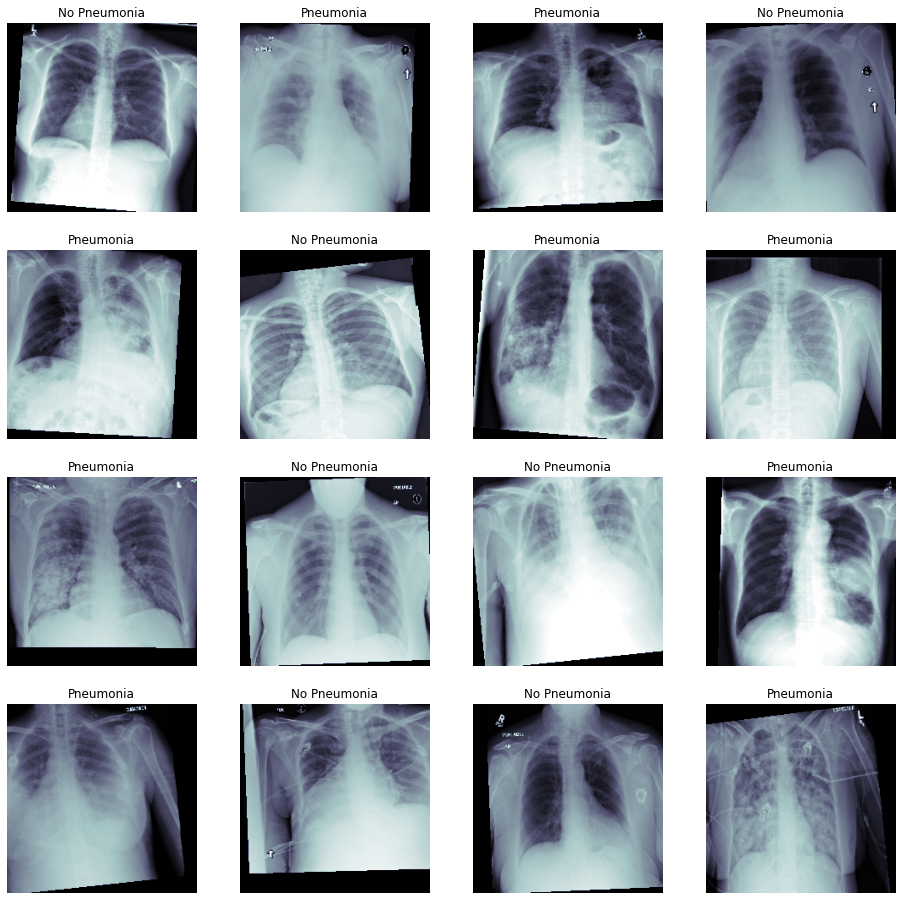

In [11]:
utils.imshow_xray_grid_labels(train_gen)

## Train Models & Save Models and Histories

In [15]:
if not all([
    os.path.isfile(
        f"{config.WEIGHT_PATH}/vgg16/{a_model}{config.WEIGHT_EXT}"
    ) for a_model in config.VGG16_ARCHITECTURES
]):
    utils.train_models(
        models = {
            k : utils.build_model("VGG16", tune_layers = v) for k, v in config.VGG16_ARCHITECTURES.items()
        }, 
        model_name = "vgg16",
        train_gen  = train_gen, 
        valid_gen  = valid_gen 
    )